## Hurdle and truncated count models

Author: Josef Perktold

Statsmodels has now hurdle and truncated count models, added in version 0.14.

A hurdle model is composed of a model for zeros and a model for the distribution for counts larger than zero. The zero model is a binary model for a count of zero versus larger than zero. The count model for nonzero counts is a zero truncated count model.

Statsmodels currently supports hurdle models with Poisson and Negative Binomial distributions as zero model and as count model. Binary models like Logit, Probit or GLM-Binomial are not yet supported as zero model.
The advantage of Poisson-Poisson hurdle is that the standard Poisson model is a special case with equal parameters in both models. This provides a simple Wald test for the hurdle model against the Poisson model.

The implemented binary model is a censored model where observations are right censored at one. That means that only 0 or 1 counts are observed.

The hurdle model can be estimated by separately estimating the zero model and the count model for the zero truncated data assuming that observations are independently distributed (no correlation across observations). The resulting covariance matrix of the parameter estimates is block diagonal with diagonal blocks given by the submodels.
Joint estimation is not yet implemented.

The censored and truncated count models were developed mainly to support the hurdle model. However, the left truncated count models have other applications than supporting the hurdle models. The right censored models are not of separate interest because they only support binary observations that can be modeled by GLM-Binomial, Logit or Probit.

For the hurdle model there is a single class `HurdleCountModel`, that includes the distributions of the submodels as option. 
Classes for truncated models are currently `TruncatedLFPoisson` and `TruncatedLFNegativeBinomialP`, where "LF" stands for left truncation at a fixed, observation independent truncation point. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.discrete.truncated_model as smtc
from statsmodels.discrete.count_model import (
    ZeroInflatedGeneralizedPoisson,
    ZeroInflatedNegativeBinomialP,
    ZeroInflatedPoisson,
)
from statsmodels.discrete.discrete_model import (
    GeneralizedPoisson,
    NegativeBinomial,
    NegativeBinomialP,
    Poisson,
)
from statsmodels.discrete.truncated_model import (
    HurdleCountModel,
    TruncatedLFNegativeBinomialP,
    TruncatedLFPoisson,
    _RCensoredPoisson,
)

## Simulating a hurdle model

We are simulating a Poisson-Poisson hurdle model explicitly because there are not yet any distribution helper functions for it.

In [2]:
np.random.seed(987456348)
# large sample to get strong results
nobs = 5000
x = np.column_stack((np.ones(nobs), np.linspace(0, 1, nobs)))

mu0 = np.exp(0.5 * 2 * x.sum(1))
y = np.random.poisson(mu0, size=nobs)
print(np.bincount(y))
y_ = y
indices = np.arange(len(y))
mask = mask0 = y > 0
for _ in range(10):

    print(mask.sum())
    indices = mask  # indices[mask]
    if not np.any(mask):
        break
    mu_ = np.exp(0.5 * x[indices].sum(1))
    y[indices] = y_ = np.random.poisson(mu_, size=len(mu_))
    np.place(y, mask, y_)
    mask = np.logical_and(mask0, y == 0)

np.bincount(y)

[102 335 590 770 816 739 573 402 265 176 116  59  35   7  11   4]
4898
602
93
11
2
0


array([ 102, 1448, 1502, 1049,  542,  234,   81,   31,    6,    5])

## Estimating misspecified Poisson Model

The data that we generated has zero deflation, this is, we observe fewer zeros than what we would expect in a Poisson model.

After fitting the model, we can use the plot function in the poisson diagnostic class to compare the expected predictive distribution and the realized frequencies. The shows that the Poisson model overestimates the number of zeros and underestimates counts of one and two.

In [3]:
mod_p = Poisson(y, x)
res_p = mod_p.fit()
print(res_p.summary())

Optimization terminated successfully.
         Current function value: 1.668079
         Iterations 4
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                 5000
Model:                        Poisson   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Jul 2025   Pseudo R-squ.:                0.008678
Time:                        15:32:00   Log-Likelihood:                -8340.4
converged:                       True   LL-Null:                       -8413.4
Covariance Type:            nonrobust   LLR p-value:                 1.279e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6532      0.019     33.642      0.000       0.615       0.691
x1             0.3871      0.

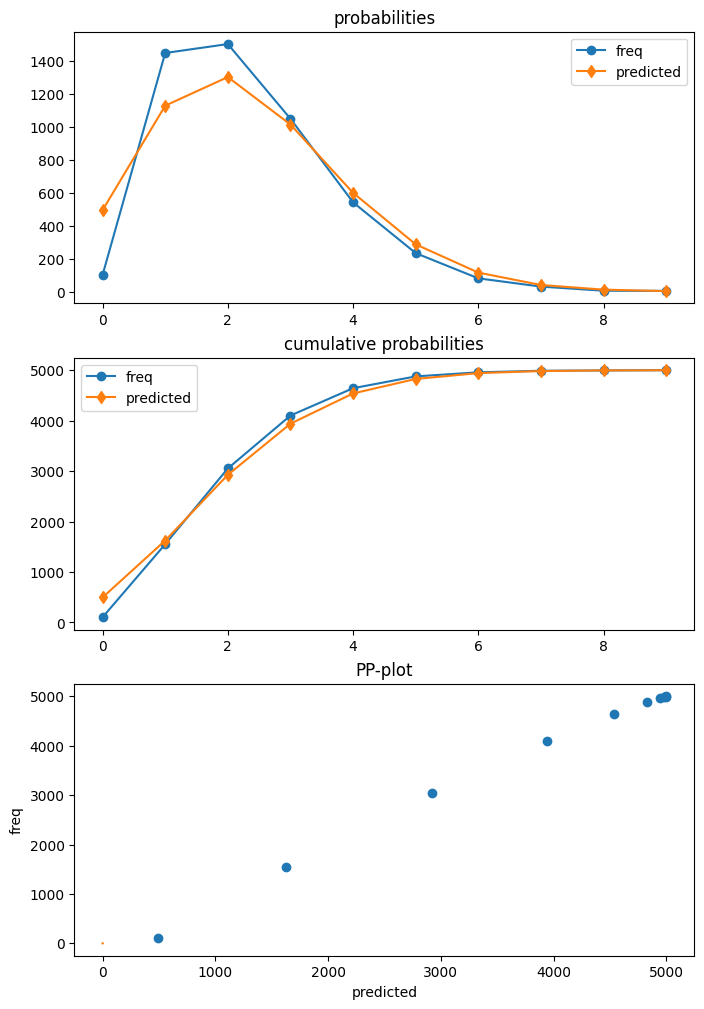

In [4]:
dia_p = res_p.get_diagnostic()
dia_p.plot_probs();

## Estimating the Hurdle Model

Next, we estimate the correctly specified Poisson-Poisson hurdle model.

Signature and options for the HurdleCountModel shows that poisson-poisson is the default, so we do not need to specify any options when creating this model.

`HurdleCountModel(endog, exog, offset=None, dist='poisson', zerodist='poisson', 
                  p=2, pzero=2, exposure=None, missing='none', **kwargs)`
                  
The results class of the HurdleCountModel has a `get_diagnostic` method. However, only part of the diagnostic methods are currently available. The plot of the predictive distribution shows very high agreement with the data.


In [5]:
mod_h = HurdleCountModel(y, x)
res_h = mod_h.fit(disp=False)
print(res_h.summary())

                     HurdleCountModel Regression Results                      
Dep. Variable:                      y   No. Observations:                 5000
Model:               HurdleCountModel   Df Residuals:                     4996
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Jul 2025   Pseudo R-squ.:                 0.01503
Time:                        15:32:01   Log-Likelihood:                -8004.9
converged:               [True, True]   LL-Null:                       -8127.1
Covariance Type:            nonrobust   LLR p-value:                 8.901e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
zm_const       0.9577      0.048     20.063      0.000       0.864       1.051
zm_x1          1.0576      0.121      8.737      0.000       0.820       1.295
const          0.5009      0.024     20.875      0.0

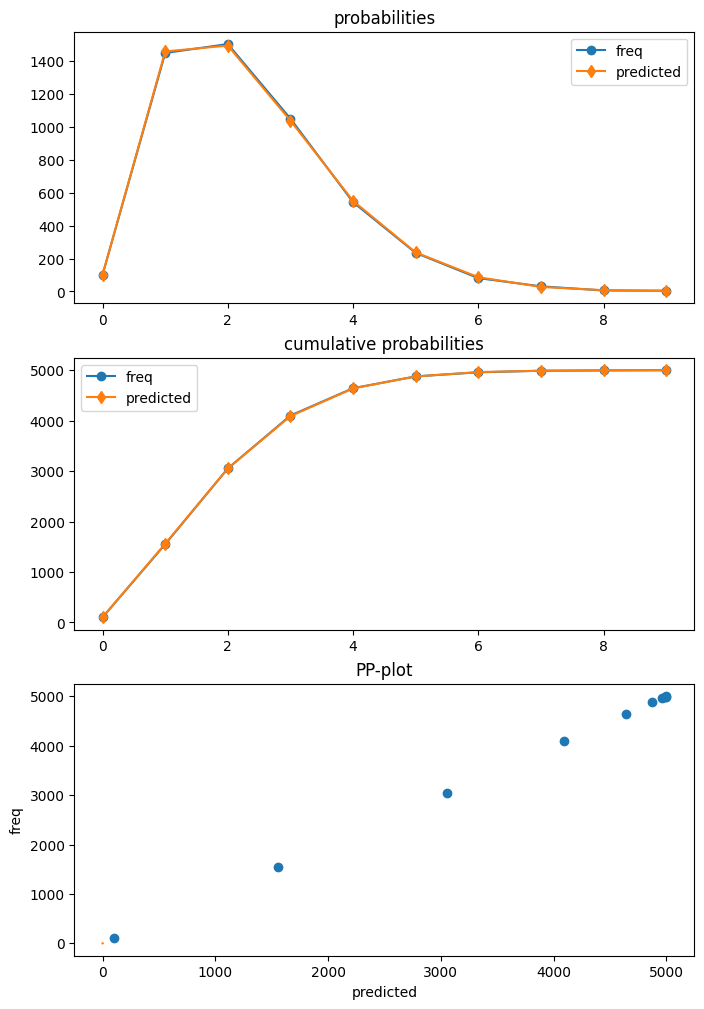

In [6]:
dia_h = res_h.get_diagnostic()
dia_h.plot_probs();

We can use the Wald test to test whether the parameters of the zero model are the same as the parameters of the zero-truncated count model. The p-value is very small and correctly rejects that the model is just Poisson. We are using a large sample size, so the power of the test will be large in this case.

In [7]:
res_h.wald_test("zm_const = const, zm_x1 = x1", scalar=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=470.67320754391915, p-value=6.231772522807044e-103, df_denom=2>

## Prediction

The hurdle model can be used for prediction for statistics of the overall model and of the two submodels. The statistics that should be predicted is specified using the `which` keyword.

The following is taken from the docstring for predict and lists available the options.

        which : str (optional)
            Statitistic to predict. Default is 'mean'.

            - 'mean' : the conditional expectation of endog E(y | x)
            - 'mean-main' : mean parameter of truncated count model.
              Note, this is not the mean of the truncated distribution.
            - 'linear' : the linear predictor of the truncated count model.
            - 'var' : returns the estimated variance of endog implied by the
              model.
            - 'prob-main' : probability of selecting the main model which is
              the probability of observing a nonzero count P(y > 0 | x).
            - 'prob-zero' : probability of observing a zero count. P(y=0 | x).
              This is equal to is ``1 - prob-main``
            - 'prob-trunc' : probability of truncation of the truncated count
              model. This is the probability of observing a zero count implied
              by the truncation model.
            - 'mean-nonzero' : expected value conditional on having observation
              larger than zero, E(y | X, y>0)
            - 'prob' : probabilities of each count from 0 to max(endog), or
              for y_values if those are provided. This is a multivariate
              return (2-dim when predicting for several observations).
              
These options are available in the `predict` and the `get_prediction` methods of the results class.

For the following example, we create a set of explanatory variables that are taken from the original data at equal spaced intervals. Then we can predict the available statistics conditional on these explanatory variables.

In [8]:
which_options = [
    "mean",
    "mean-main",
    "linear",
    "mean-nonzero",
    "prob-zero",
    "prob-main",
    "prob-trunc",
    "var",
    "prob",
]
ex = x[slice(None, None, nobs // 5), :]
ex

array([[1.        , 0.        ],
       [1.        , 0.20004001],
       [1.        , 0.40008002],
       [1.        , 0.60012002],
       [1.        , 0.80016003]])

In [9]:
for w in which_options:
    print(w)
    pred = res_h.predict(ex, which=w)
    print("    ", pred)

mean
     [1.89150663 2.07648059 2.25555158 2.43319456 2.61673457]
mean-main
     [1.65015181 1.8083782  1.98177629 2.17180081 2.38004602]
linear
     [0.50086729 0.59243042 0.68399356 0.77555669 0.86711982]
mean-nonzero
     [2.04231955 2.16292424 2.29857565 2.45116551 2.62277411]
prob-zero
     [0.07384394 0.0399661  0.01871771 0.00733159 0.00230273]
prob-main
     [0.92615606 0.9600339  0.98128229 0.99266841 0.99769727]
prob-trunc
     [0.19202076 0.16391977 0.1378242  0.11397219 0.09254632]
var
     [1.43498239 1.51977118 1.63803729 1.7971727  1.99738345]
prob
     [[7.38439416e-02 3.63208532e-01 2.99674608e-01 1.64836199e-01
  6.80011882e-02 2.24424568e-02 6.17224344e-03 1.45501981e-03
  3.00125448e-04 5.50280612e-05]
 [3.99660987e-02 3.40376213e-01 3.07764462e-01 1.85518182e-01
  8.38717591e-02 3.03343722e-02 9.14266959e-03 2.36191491e-03
  5.33904431e-04 1.07277904e-04]
 [1.87177088e-02 3.10869602e-01 3.08037002e-01 2.03486809e-01
  1.00816333e-01 3.99590837e-02 1.31983274e-02 3

In [10]:
for w in which_options[:-1]:
    print(w)
    pred = res_h.get_prediction(ex, which=w)
    print("    ", pred.predicted)
    print("  se", pred.se)

mean
     [1.89150663 2.07648059 2.25555158 2.43319456 2.61673457]
  se [0.07877461 0.05693768 0.05866892 0.09551274 0.15359057]
mean-main
     [1.65015181 1.8083782  1.98177629 2.17180081 2.38004602]
  se [0.03959242 0.03164634 0.02471869 0.02415162 0.03453261]
linear
     [0.50086729 0.59243042 0.68399356 0.77555669 0.86711982]
  se [0.04773779 0.03148549 0.02960421 0.04397859 0.06453261]
mean-nonzero
     [2.04231955 2.16292424 2.29857565 2.45116551 2.62277411]
  se [0.02978486 0.02443098 0.01958745 0.0196433  0.02881753]
prob-zero
     [0.07384394 0.0399661  0.01871771 0.00733159 0.00230273]
  se [0.00918583 0.00405155 0.00220446 0.00158494 0.00090255]
prob-main
     [0.92615606 0.9600339  0.98128229 0.99266841 0.99769727]
  se [0.00918583 0.00405155 0.00220446 0.00158494 0.00090255]
prob-trunc
     [0.19202076 0.16391977 0.1378242  0.11397219 0.09254632]
  se [0.00760257 0.00518746 0.00340683 0.00275261 0.00319587]
var
     [1.43498239 1.51977118 1.63803729 1.7971727  1.99738345]


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/statsmodels/base/_prediction_inference.py:783: UserWarning: using default log-link in get_prediction
  warnings.warn("using default log-link in get_prediction")


The option `which="prob"` returns an array of predicted probabilities for each row of the predict `exog`.
We are often interested in the mean probabilities averaged over all exog. The prediction methods have an option `average=True` to compute the average of the predicted values across observations and the corresponding standard errors and confidence intervals for those averaged predictions.

In [11]:
pred = res_h.get_prediction(ex, which="prob", average=True)
print("    ", pred.predicted)
print("  se", pred.se)

     [2.84324139e-02 3.06788002e-01 3.00960210e-01 2.00095571e-01
 1.01418732e-01 4.17809876e-02 1.45620174e-02 4.41222267e-03
 1.18509193e-03 2.86300514e-04]
  se [2.81472152e-03 5.00830805e-03 1.37524763e-03 1.87343644e-03
 1.99068649e-03 1.23878525e-03 5.78099173e-04 2.21180110e-04
 7.25021189e-05 2.08872558e-05]


We use the panda DataFrame to get a display that is easier to read. The "predicted" column shows the probability mass function for the predicted distribution of response values averaged of our 5 grid points of exog. The probabilities do not add up to one because counts larger than those observed have positive probability and are missing in the table, although in this example that probability is small.

In [12]:
dfp_h = pred.summary_frame()
dfp_h

predicted        se  ci_lower  ci_upper
0   0.028432  0.002815  0.022916  0.033949
1   0.306788  0.005008  0.296972  0.316604
2   0.300960  0.001375  0.298265  0.303656
3   0.200096  0.001873  0.196424  0.203767
4   0.101419  0.001991  0.097517  0.105320
5   0.041781  0.001239  0.039353  0.044209
6   0.014562  0.000578  0.013429  0.015695
7   0.004412  0.000221  0.003979  0.004846
8   0.001185  0.000073  0.001043  0.001327
9   0.000286  0.000021  0.000245  0.000327

In [13]:
prob_larger9 = pred.predicted.sum()
prob_larger9, 1 - prob_larger9

(np.float64(0.9999215487936677), np.float64(7.84512063323195e-05))

`get_prediction` returns in this case an instance of the base `PredictionResultsDelta` class.

Inferential statistics like standard errors, p-values and confidence interval for nonlinear functions that depend on several distribution parameters are computed using the delta method. Inference for predictions is based on the normal distribution. 

In [14]:
pred

In [15]:
pred.dist, pred.dist_args

(<scipy.stats._continuous_distns.norm_gen at 0x7fa4b7e96410>, ())

We can compare the distribution predicted by the hurdle model with the one predicted by the Poisson model that we estimated earlier. The last column, "diff", shows that Poisson model overestimates the number of zeros by around 8% of observations and underestimates the counts of 1 and 2 by 7%, resp. 3.7% at the average over the `exog` grid.

In [16]:
pred_p = res_p.get_prediction(ex, which="prob", average=True)
dfp_p = pred_p.summary_frame()
dfp_h["poisson"] = dfp_p["predicted"]
dfp_h["diff"] = dfp_h["poisson"] - dfp_h["predicted"]
dfp_h

predicted        se  ci_lower  ci_upper   poisson      diff
0   0.028432  0.002815  0.022916  0.033949  0.107848  0.079416
1   0.306788  0.005008  0.296972  0.316604  0.237020 -0.069768
2   0.300960  0.001375  0.298265  0.303656  0.263523 -0.037437
3   0.200096  0.001873  0.196424  0.203767  0.197657 -0.002439
4   0.101419  0.001991  0.097517  0.105320  0.112511  0.011093
5   0.041781  0.001239  0.039353  0.044209  0.051833  0.010052
6   0.014562  0.000578  0.013429  0.015695  0.020124  0.005561
7   0.004412  0.000221  0.003979  0.004846  0.006769  0.002356
8   0.001185  0.000073  0.001043  0.001327  0.002012  0.000827
9   0.000286  0.000021  0.000245  0.000327  0.000537  0.000250

## Other post-estimation

The estimated hurdle model can be use for wald test of parameters and for prediction. Other maximum likelihood statistics such as loglikelihood value and information criteria are also available. 

However, some post-estimation methods that require helper functions that are not needed for estimation, parameter inference and prediction are not yet available. The main methods that are not supported yet are `score_test`, `get_distribution`, and `get_influence`. Diagnostic measures in `get_diagnostics` are only available for statistics that are based on prediction.



In [17]:
res_h.llf, res_h.df_resid, res_h.aic, res_h.bic

(np.float64(-8004.904002793644),
 4996,
 np.float64(16017.808005587289),
 np.float64(16043.876778352953))

Is there excess dispersion? We can use the pearson residuals to compute a pearson chi2 statistics which should be close to 1 if the model is correctly specified.

In [18]:
(res_h.resid_pearson**2).sum() / res_h.df_resid

np.float64(0.9989670114949286)

The diagnostic class also has the predictive distribution which is used in the diagnostic plots. No other statistics or tests are currently availalbe.

In [19]:
dia_h.probs_predicted.mean(0)

array([0.02044612, 0.29147174, 0.29856288, 0.20740118, 0.10990976,
       0.04737579, 0.0172898 , 0.00548983, 0.00154646, 0.00039214])

In [20]:
res_h.resid[:10]

array([ 1.10849337,  1.10830496, -0.89188344, -0.89207183,  1.10773978,
       -0.8924486 , -0.89263697,  0.10717466,  0.1069863 ,  0.10679794])